In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, correlate
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import butter, lfilter


## Définition de fonctions utiles au programme

In [10]:
def autocorr(x):
    R = correlate(x, x, mode='full') / len(x)
    # lags = np.arange(-len(x) + 1, len(x))
    return R

# def estimate_dsp_from_autocorr(R, fs):
#    R_centered = R[len(R)//2:]  # partie causale
#    S = np.abs(fft(R_centered))
#    freqs = fftfreq(len(S), d=1/fs)
#    return freqs[:len(freqs)//2], S[:len(S)//2]  # partie positive

def autocorr_moyenne(signal_generator, nb_real, N):
    autocorr_sum = np.zeros(2*N - 1)
    for _ in range(nb_real):
        x = signal_generator(N)
        R = correlate(x, x, mode='full') / N
        autocorr_sum += R
    R_avg = autocorr_sum / nb_real
    return R_avg

def densite_spectral_puissance(R):
    R_causal = R[N-1:]
    S = np.abs(fft(R_causal))
    freqs = fftfreq(len(S), d=1/fs)
    return freqs[:len(freqs)//2], S[:len(S)//2]


## Definition des 4 signaux de base

In [11]:
# Paramètres
fs = 1000  # Hz
T = 1  # durée en secondes
N = fs * T
t = np.linspace(0, T, N, endpoint=False)

In [12]:
# x1 : bruit blanc
def bruit_blanc(N):
    return np.random.normal(0, 1, N)

# x2 : bruit blanc filtré passe-bas
def bruit_filtre_pb(N):
    x = np.random.normal(0, 1, N)
    b, a = butter(N=4, Wn=0.2)  # filtre passe-bas
    return lfilter(b, a, x)

# x3 : bruit blanc filtré passe-haut
def bruit_filtre_ph(N):
    x = np.random.normal(0, 1, N)
    b, a = butter(N=4, Wn=0.2, btype='high')  # filtre passe-haut
    return lfilter(b, a, x)

# x4 : bruit blanc filtré passe-haut
def sinus_plus_bruit_blanc(N):
    t = np.arange(N) / 1000 # (=Fréquence d'échantillonnage en Hz)
    return np.sin(2 * np.pi * 50 * t) + np.random.normal(0, 1, N)

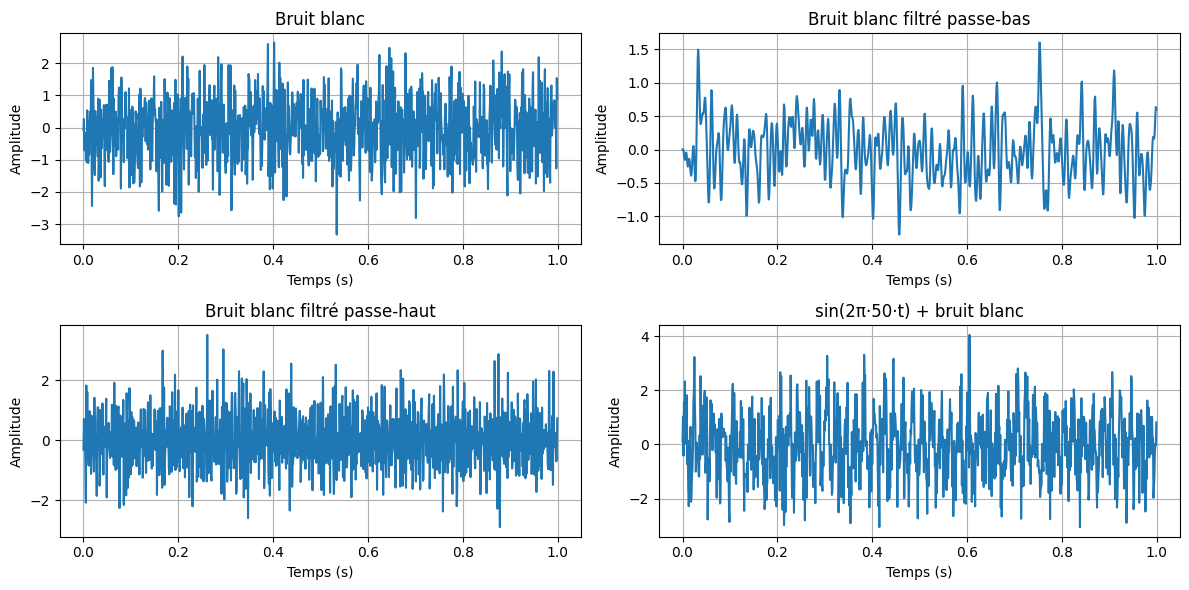

In [13]:
# Affichage des 4 signaux

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(t, bruit_blanc(N))
plt.title("Bruit blanc")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(t, bruit_filtre_pb(N))
plt.title("Bruit blanc filtré passe-bas")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(t, bruit_filtre_ph(N))
plt.title("Bruit blanc filtré passe-haut")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()

# c. DSP estimée zoomée
plt.subplot(2, 2, 4)
plt.plot(t, sinus_plus_bruit_blanc(N))
plt.title("sin(2π·50·t) + bruit blanc")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

## Analyse du bruit blanc gaussian d'écart type $\sigma$

Un bruit blanc gaussien est un signal qui a les propriétés suivantes
- Il est aléatoire : chaque échantillon du signal est tiré indépendamment d'un bruit aléatoire.
- Il suit une distribution gaussienne : chaque échantillon a une probabilité de valeur qui suit une courbe en cloche (la loi normale).
- Il est stationnaire : sa moyenne et sa variance ne changent pas avec le temps.

La fonction d'autocorrélation $R_{xx}(\tau)$​ mesure la similarité entre un signal et une version décalée de lui-même.

Pour un bruit blanc gaussien idéal, le signal est complètement décorrélé entre les échantillons. Cela signifie que les valeurs du signal à deux instants différents sont totalement indépendantes les unes des autres. La fonction d'autocorrélation de ce signal doit donc satisfaire les conditions suivantes :
- À $\tau=0$ (c'est-à-dire quand on compare un échantillon avec lui-même), la corrélation est maximale, et c'est égal à la variance du bruit $\sigma^2$ (puisque la variance mesure la "puissance" du bruit).
- À $\tau \neq0$, la corrélation est nulle. Cela signifie qu'il n'y a aucune dépendance entre les échantillons à des instants différents.

Cela signifie que la fonction d'autocorrélation du bruit blanc gaussien est :
$$R_{xx}(\tau)=\sigma^2 \, \delta(\tau)$$


et sa densité spectrale de puissance est :
$$S_{xx}(f) = TF(R_{xx}(\tau))=\int_{-\infty}^{\infty} \sigma^2 \, \delta(\tau) \cdot e^{-j2 \pi f \tau} \, d\tau$$
$$S_{xx}(f) = TF(R_{xx}(\tau))=\sigma^2 \, \int_{-\infty}^{\infty} \delta(\tau) \, d\tau$$

### Etude pour une seul réalisaton temporelle

In [20]:
x = bruit_blanc(N) # Réalisation temporelle
R = autocorr(x)
freqs, S = densite_spectral_puissance(R)

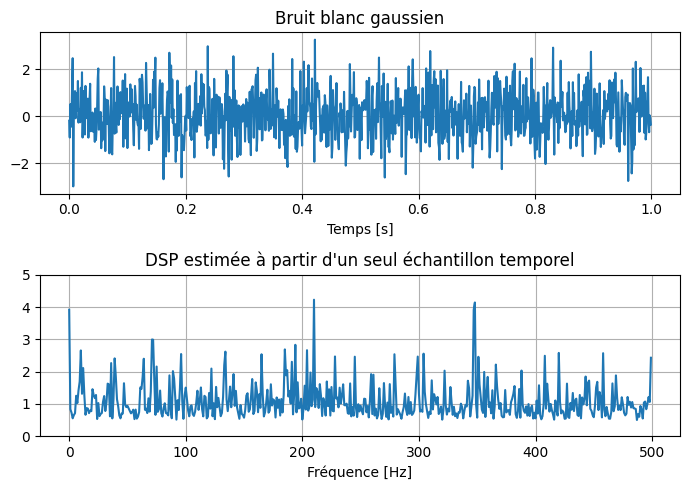

In [21]:
plt.figure(figsize=(7, 5))

# Signal temporel
plt.subplot(2, 1, 1)
plt.plot(t, x)
plt.title("Bruit blanc gaussien")
plt.xlabel("Temps [s]")
plt.grid()

# DSP estimée
plt.subplot(2, 1, 2)
plt.plot(freqs, S)
plt.title("DSP estimée à partir d'un seul échantillon temporel")
plt.xlabel("Fréquence [Hz]")
plt.ylim(0, 5)
plt.grid()

plt.tight_layout()
plt.show()

### Etude pour 100 réalisations temporelles permettant de moyenner les résultats

In [27]:
nb_real = 100    # nombre de réalisations pour la moyenne

R_moy = autocorr_moyenne(bruit_blanc, nb_real, N)
freqs, S_moy = densite_spectral_puissance(R_moy)

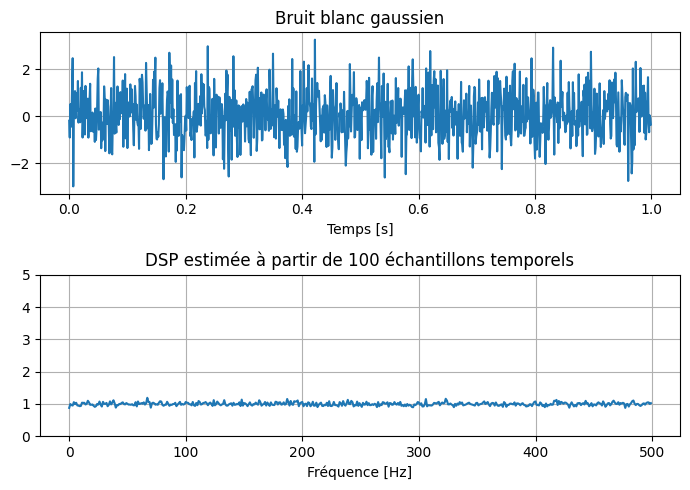

In [28]:
plt.figure(figsize=(7, 5))

# Signal temporel
plt.subplot(2, 1, 1)
plt.plot(t, x)
plt.title("Bruit blanc gaussien")
plt.xlabel("Temps [s]")
plt.grid()

# DSP estimée
plt.subplot(2, 1, 2)
plt.plot(freqs, S_moy)
plt.title(f"DSP estimée à partir de {nb_real} échantillons temporels")
plt.xlabel("Fréquence [Hz]")
plt.ylim(0, 5)
plt.grid()

plt.tight_layout()
plt.show()

## Analyse des bruits blancs gaussiens filtrés

In [32]:
# ------ Traitement et affichage ------

signaux = {
    "Bruit blanc": bruit_blanc,
    "Bruit filtré passe-bas": bruit_filtre_pb,
    "Bruit filtré passe-haut": bruit_filtre_ph,
}

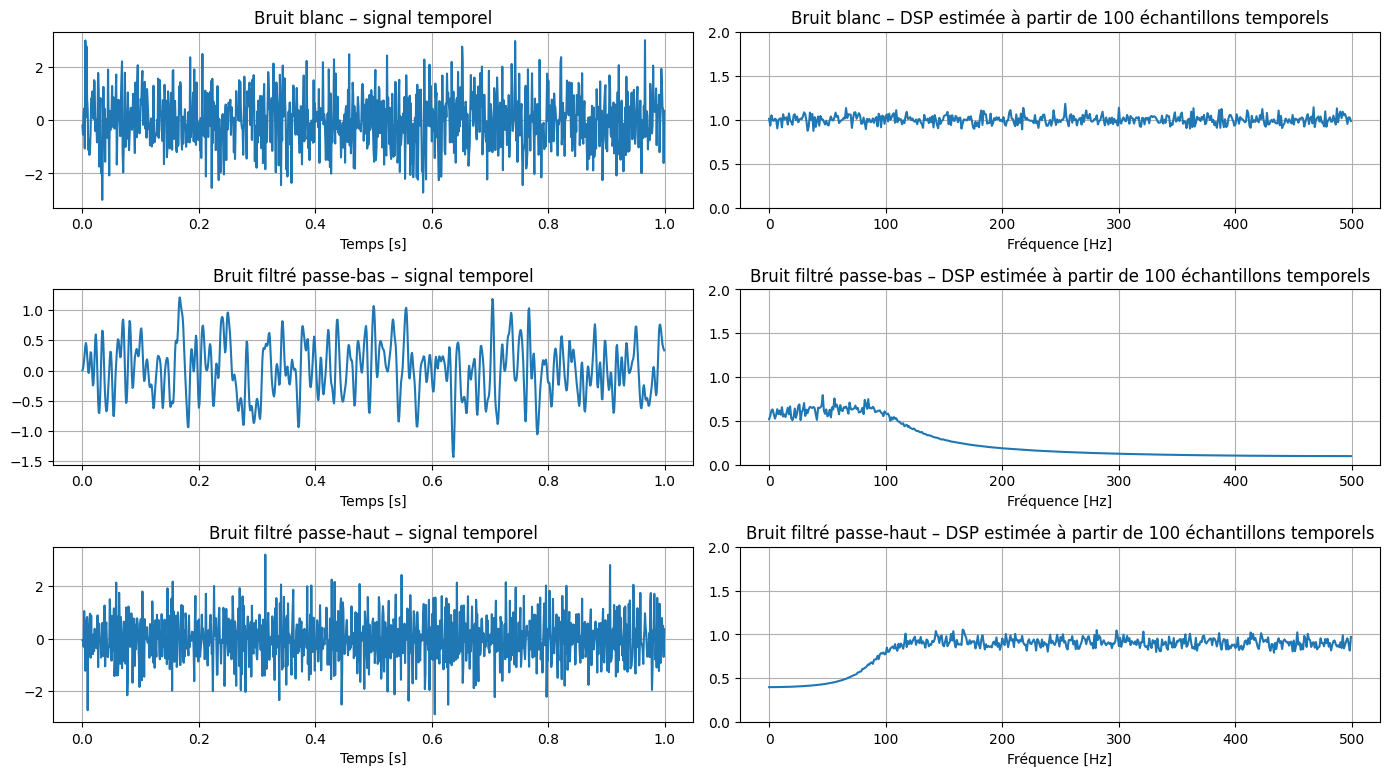

In [34]:
plt.figure(figsize=(14, 10))

for i, (nom, generateur) in enumerate(signaux.items()):
    x_temp = generateur(N)                          # 1 réalisation pour affichage temporel
    R_avg = autocorr_moyenne(generateur, nb_real, N)
    freqs, S = densite_spectral_puissance(R_avg)

    # Signal temporel
    plt.subplot(4, 2, 2*i + 1)
    plt.plot(np.arange(N) / fs, x_temp)
    plt.title(f"{nom} – signal temporel")
    plt.xlabel("Temps [s]")
    plt.grid()

    # DSP estimée
    plt.subplot(4, 2, 2*i + 2)
    plt.plot(freqs, S)
    plt.title(f"{nom} – DSP estimée à partir de {nb_real} échantillons temporels")
    plt.xlabel("Fréquence [Hz]")
    plt.ylim(0, 2)
    plt.grid()

plt.tight_layout()
plt.show()

## Analyse des signaux sinusoidaux avec ajout d'un bruit blanc gaussien

In [38]:
x1_tmp = sinus_plus_bruit_blanc(N)
R = autocorr(sinus_plus_bruit_blanc(N))
freqs, S = densite_spectral_puissance(R)

x2_tmp = sinus_plus_bruit_blanc(N)
R_moy = autocorr_moyenne(sinus_plus_bruit_blanc, nb_real, N)
freqs, S_moy = densite_spectral_puissance(R_moy)

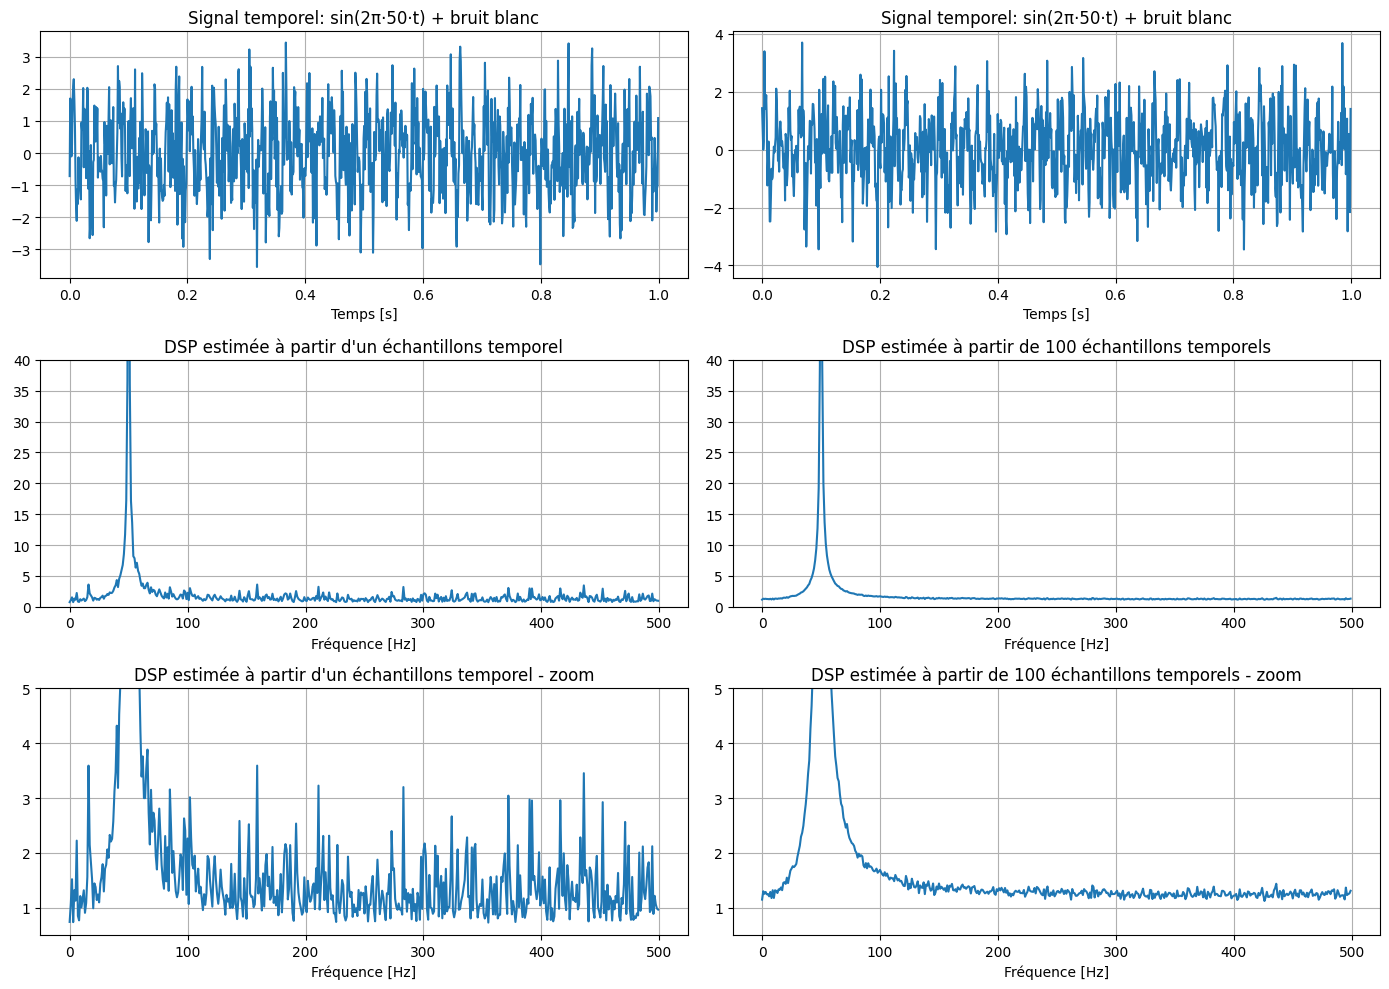

In [48]:
plt.figure(figsize=(14, 10))

# Signal temporel 1
plt.subplot(3, 2, 1)
plt.plot(t, x1_tmp)
plt.title("Signal temporel: sin(2π·50·t) + bruit blanc")
plt.xlabel("Temps [s]")
plt.grid()

# Signal temporel 2
plt.subplot(3, 2, 2)
plt.plot(t, x2_tmp)
plt.title("Signal temporel: sin(2π·50·t) + bruit blanc")
plt.xlabel("Temps [s]")
plt.grid()

# DSP estimée 1
plt.subplot(3, 2, 3)
plt.plot(freqs, S)
plt.title(f"DSP estimée à partir d'un échantillons temporel")
plt.xlabel("Fréquence [Hz]")
plt.ylim(0, 40)
plt.grid()

# DSP estimée 2
plt.subplot(3, 2, 4)
plt.plot(freqs, S_moy)
plt.title(f"DSP estimée à partir de {nb_real} échantillons temporels")
plt.xlabel("Fréquence [Hz]")
plt.ylim(0, 40)
plt.grid()

# DSP estimée 1 - zoom
plt.subplot(3, 2, 5)
plt.plot(freqs, S)
plt.title(f"DSP estimée à partir d'un échantillons temporel - zoom")
plt.xlabel("Fréquence [Hz]")
plt.ylim(0.5, 5)
plt.grid()

# DSP estimée 2 - zoom
plt.subplot(3, 2, 6)
plt.plot(freqs, S_moy)
plt.title(f"DSP estimée à partir de {nb_real} échantillons temporels - zoom")
plt.xlabel("Fréquence [Hz]")
plt.ylim(0.5, 5)
plt.grid()


plt.tight_layout()
plt.show()